In [20]:
import pickle
import json

import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, utils, decomposition, model_selection, linear_model, discriminant_analysis, svm, tree, ensemble

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import matplotlib.pyplot as plt


In [21]:
data = None

with open('full_factorial/all_experiments_full_factorial.pickle', 'rb') as f:
    data = pickle.load(f)

In [22]:
configs = None

with open('full_factorial/experiment_data_with_id_full_factorial.json') as f:
    configs = json.load(f)

In [116]:
configs_df = pd.read_csv('full_factorial/full_factorial_configs_as_df.csv')


## Actual analysis

### Power calculation

In [24]:
# TDP/core

# Skylake, Broadwell, Haswell, AMD EPYC Rome, and AMD EPYC Milan
# 6700: 65/4, 5775c: 65/8, 4770:  84/4, EPYC 7352: 155/24, EPYC 7443: 200/24

tdp_per_core = sum([65/4, 65/8, 84/4, 155/24, 200/24]) / 5

tdp_per_core

12.033333333333335

### Plot loaded data

In [25]:
columns_to_plot = list(data[list(data.keys())[0]].columns)

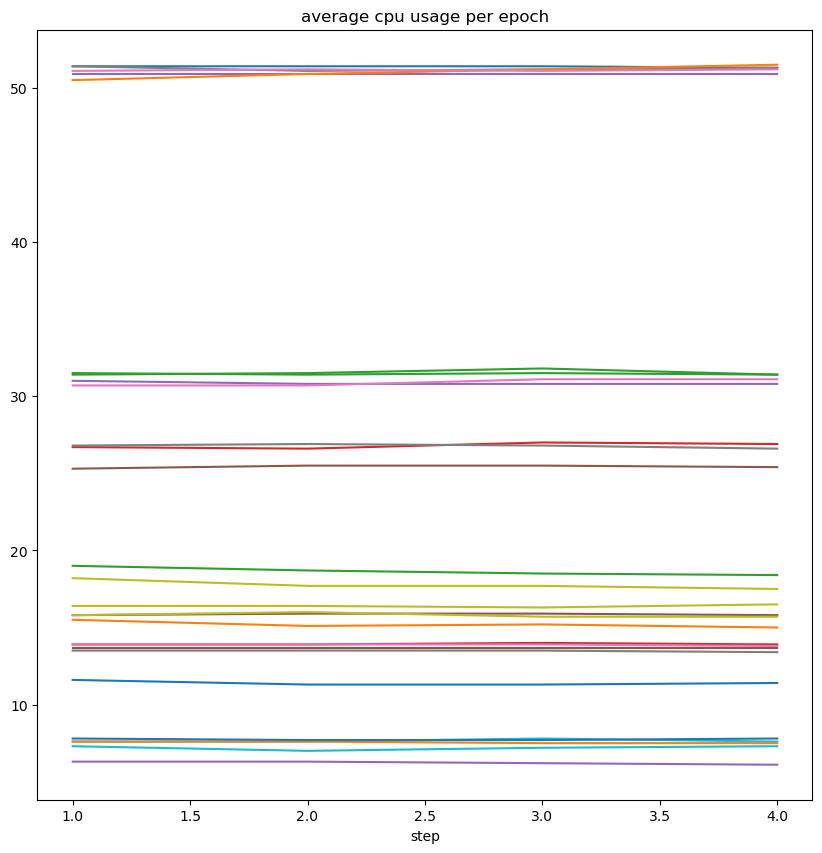

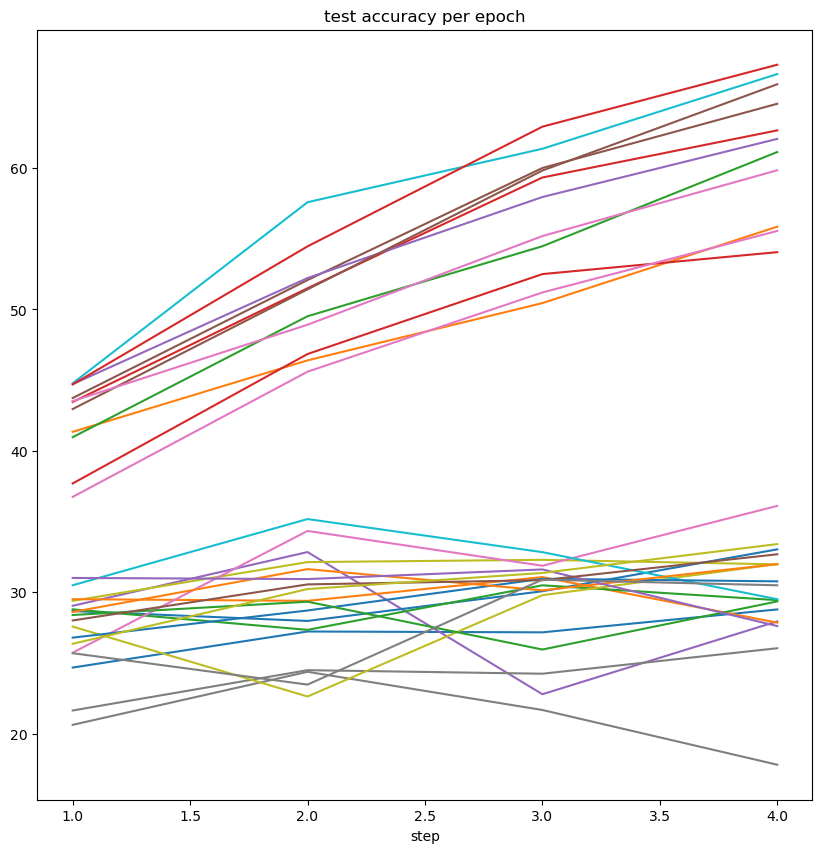

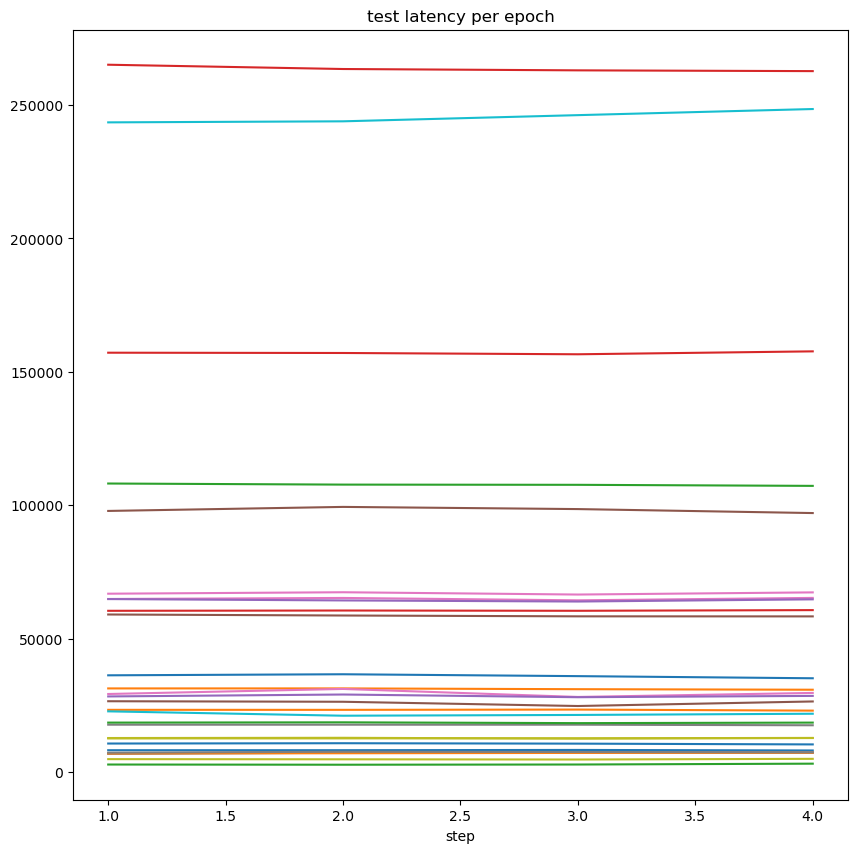

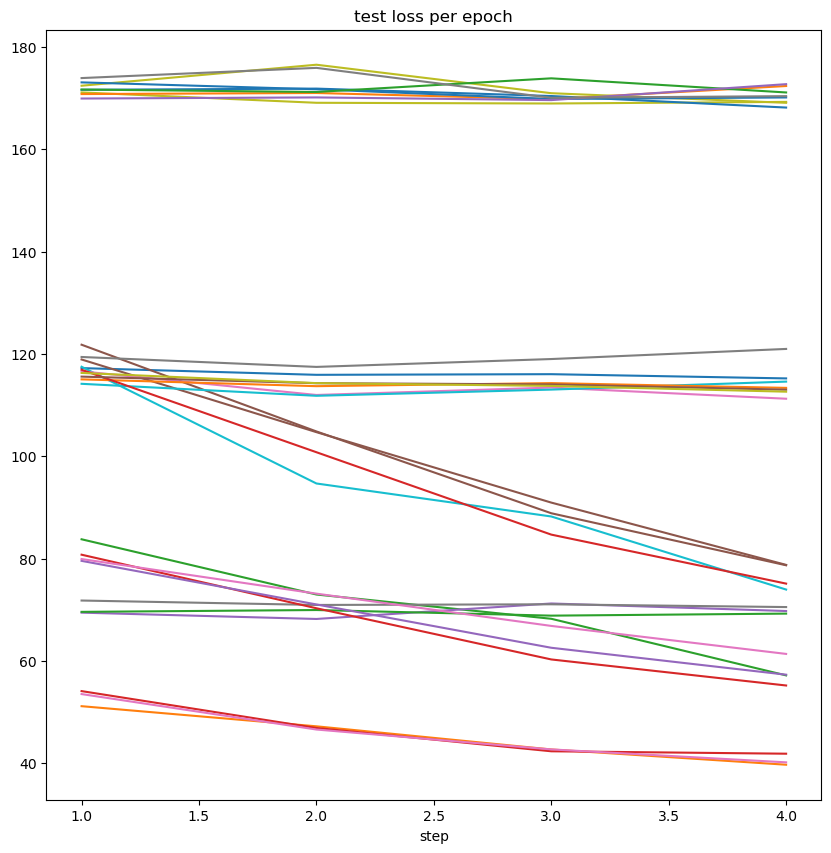

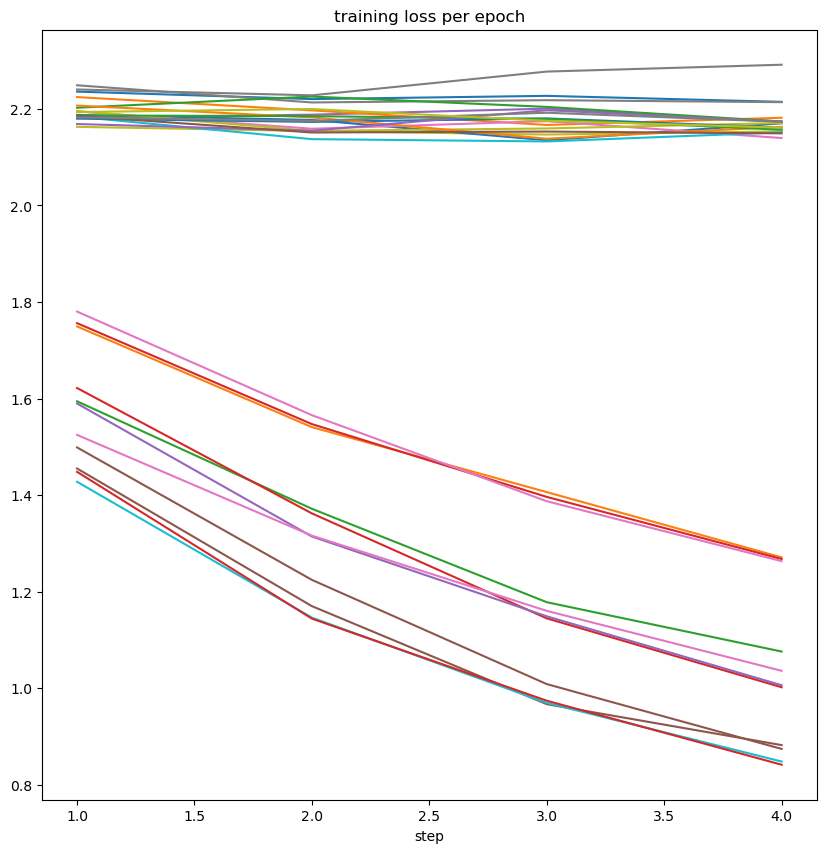

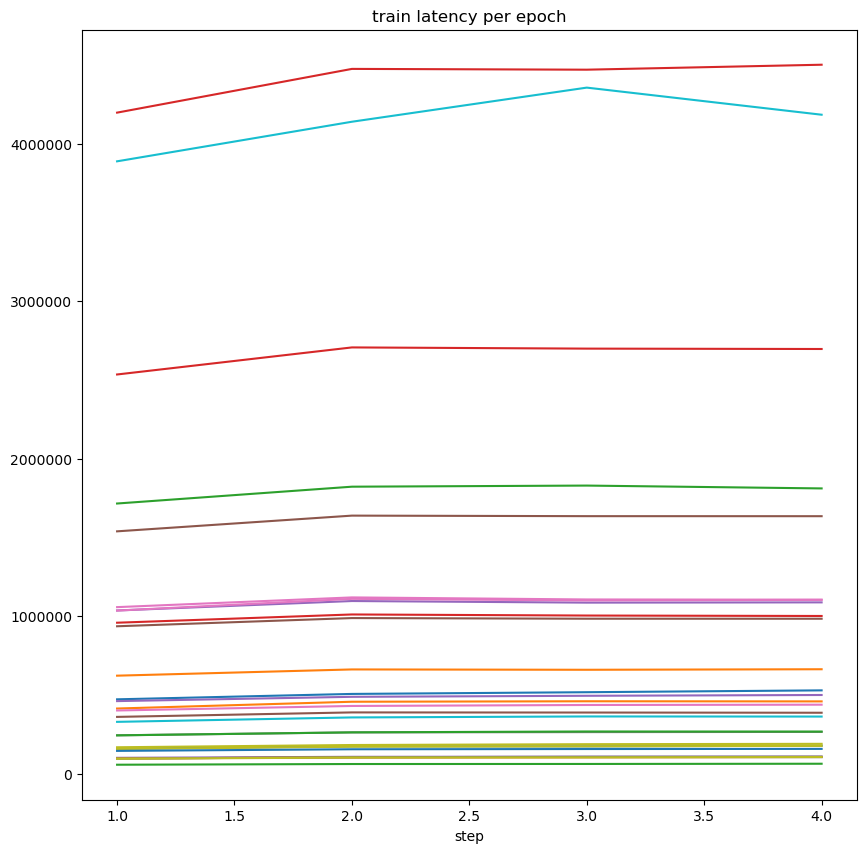

In [26]:
for column in columns_to_plot:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    for key in data:
        data[key].plot(x=None, y=column, title=key, ax=ax, legend=False)

    plt.title(column)
    plt.show()

### Setup

In [27]:
def prepare_data(X, y):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = preprocessing.StandardScaler().fit(X, y)

    # ... and scale the features
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [137]:
# NETWORK_TO_FIT = "Cifar10CNN" # Cifar10ResNet
NETWORK_TO_FIT = "Cifar10ResNet"

network_data = configs_df[configs_df['model'] == NETWORK_TO_FIT]



In [138]:
# UPDATE HERE THE COLUMNS YOU WANT TO USE FOR THE FITTING
X = network_data[[
#  'batch_size',
#  'test_batch_size',
 'Paralell',
#  'Memory',
 'CPU',
 ]]

# UPDATE HERE THE COLUMN THAT YOU WANT TO PREDICT
y = network_data['mean train latency per epoch'] + network_data['mean test latency per epoch']  #Sum of latencies is service time

### Linear regression (basic, no optimization)

In [139]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('R2: \n', regr.score(X, y))

Intercept: 
 1659360.9790138411
Coefficients: 
 [ -92767.36077616 -569621.48291302]
R2: 
 0.8420672949456577


### Hyperparam search

In [140]:
X_train, X_test, y_train, y_test = prepare_data(X, y)

In [ ]:

opt = BayesSearchCV(
    ensemble.RandomForestRegressor(),
    {
        # 'bootstrap': [True, False],
        # 'max_depth': Integer(10,20),
        # 'max_features': ["sqrt", "log2", None],
        # 'min_samples_leaf': Integer(10,20),
        # 'min_samples_split': Integer(10,20),
        'n_estimators': Integer(1,150)
    },
    # error_score=0.0,
    n_iter=16,
    cv=5,
    verbose=5
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

# Print best params
print("best params: %s" % str(opt.best_params_))



In [141]:
from sklearn import ensemble
from ray import air, tune
from ray.tune.sklearn import TuneGridSearchCV
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneSearchCV
import random


def trainrf(config):
    rf = ensemble.RandomForestRegressor(
        bootstrap=config["bootstrap"], 
        max_depth=config["max_depth"], 
        max_features=config["max_features"], 
        min_samples_leaf=config["min_samples_leaf"],
        min_samples_split=config["min_samples_split"],
        n_estimators=config["n_estimators"]).fit(X_train, y_train)
    accuracy = rf.score(X_test, y_test)
    feature_importances = rf.feature_importances_
    tune.report(mean_accuracy=accuracy)

# [bootstrap, max depth, max features, min samples leaf, min samples split,n estimators]
parameter_grid = {
    "bootstrap": tune.choice([True]), 
    "max_depth": tune.grid_search([1,2,3,4,5,6,7,8,9,10, None]), 
    "max_features": tune.grid_search(["sqrt", "log2", None]), 
    "min_samples_leaf": tune.choice([tune.randint(1,10), tune.uniform(0, 10)]), 
    "min_samples_split": tune.choice([tune.randint(2,10), tune.uniform(0, 1)]), 
    "n_estimators": tune.grid_search(np.arange(1, 100))
    }

tuner_rf = tune.Tuner(
    trainrf,
    param_space=parameter_grid,
)
results = tuner_rf.fit()
best_result_rf = results.get_best_result(metric="mean_accuracy", mode='max')
best_result_rf


Result for trainrf_2d3e1_00000:
  date: 2022-10-30_00-01-09
  done: false
  experiment_id: 4e374d7a842b42da8ac152c3b103a6e2
  hostname: hugo-VivoBook-ASUSLaptop-X431FL-S431FL
  iterations_since_restore: 1
  mean_accuracy: -0.006630185200074079
  node_ip: 192.168.1.66
  pid: 194098
  time_since_restore: 0.0047914981842041016
  time_this_iter_s: 0.0047914981842041016
  time_total_s: 0.0047914981842041016
  timestamp: 1667080869
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 2d3e1_00000
  warmup_time: 0.004441976547241211
  
Result for trainrf_2d3e1_00000:
  date: 2022-10-30_00-01-09
  done: true
  experiment_id: 4e374d7a842b42da8ac152c3b103a6e2
  experiment_tag: 0_bootstrap=True,max_depth=1,max_features=sqrt,min_samples_leaf=5.5763,min_samples_split=0.7037,n_estimators=1
  hostname: hugo-VivoBook-ASUSLaptop-X431FL-S431FL
  iterations_since_restore: 1
  mean_accuracy: -0.006630185200074079
  node_ip: 192.168.1.66
  pid: 194098
  time_since_restore: 0.0047914981842041016


2022-10-30 00:05:00,436	INFO tune.py:758 -- Total run time: 238.74 seconds (236.62 seconds for the tuning loop).


Result(metrics={'mean_accuracy': 0.9666614005587275, 'done': True, 'trial_id': '2d3e1_01546', 'experiment_tag': '1546_bootstrap=True,max_depth=7,max_features=None,min_samples_leaf=1,min_samples_split=0.2501,n_estimators=47'}, error=None, log_dir=PosixPath('/home/hugo/ray_results/trainrf_2022-10-30_00-01-01/trainrf_2d3e1_01546_1546_bootstrap=True,max_depth=7,max_features=None,min_samples_leaf=1,min_samples_split=0.2501,n_estimators=47_2022-10-30_00-02-23'))

### Best config for CNN

In [115]:
rf2 = ensemble.RandomForestRegressor(bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=0.0671, n_estimators=3)
rf2.fit(X_train, y_train)
print(rf2.score(X_test, y_test))

0.9184627824408311


### Best config for ResNet

In [124]:
rf2 = ensemble.RandomForestRegressor(bootstrap=False, max_depth=9, max_features=None, min_samples_leaf=1, min_samples_split=0.2409, n_estimators=1)
rf2.fit(X_train, y_train)
print(rf2.score(X_test, y_test))

0.9651590310319442
